In [1]:
import pandas as pd
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAPI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI
chat_model = ChatOpenAI(model="gpt-4o-mini")

In [5]:
import requests

def get_response(url, headers, data):
    response = requests.request("POST", url, headers=headers, data=data)
    return json.loads(response.text)

In [6]:
from calendar import monthrange

def update_payload(current_month):
    # global payload_dict
    payload_dict= {
        'payload_aggregate': {
            'filters': {
                'startDate': '2024-07-01',
                'endDate': '2024-08-31',
                'aggregateField': 'CATEGORY',
                'products': ['JUPITER', 'ADA']
            }
        }
    }
    from datetime import datetime
    current_month_date = datetime.strptime(current_month, "%Y-%m")
    
    start_date = current_month_date.replace(day=1).strftime("%Y-%m-%d")
    last_day = monthrange(current_month_date.year, current_month_date.month)[1]
    end_date = current_month_date.replace(day=last_day).strftime("%Y-%m-%d")
    
    payload_dict['payload_aggregate']['filters']['startDate'] = start_date
    payload_dict['payload_aggregate']['filters']['endDate'] = end_date
    return payload_dict

In [7]:
def extract_data(data):
    categories = []
    amount = []
    cat_percentage = []
    credit_debit_indicators = []

    this_month_data = data['aggregateData']
    for entry in this_month_data:
        credit_debit = entry['creditDebitIndicator']
        for field in entry['aggregateFields']:
            categories.append(field['name'])
            amount.append(field['amount'])
            cat_percentage.append(field['percentage'])
            credit_debit_indicators.append(credit_debit)
    
    df = pd.DataFrame({
        'category': categories,
        'creditDebitIndicator': credit_debit_indicators,
        'amount': amount,
        'category%': cat_percentage
    })
    return df

In [8]:
import json
import pandas as pd

def get_spend_insights_for_user(user_id, current_month,past_month):
    #1. get all data needed
    
    #1a: get or set API query params and call API
    url_aggregate="http://localhost:9003/wealth/v1/insights/aggregate"
    payload_dict = update_payload(current_month)
    payload_aggregate = json.dumps(payload_dict["payload_aggregate"])
    headers_aggregate = {
        'Content-Type': 'application/json',
        'X-App-Version': '2.4.5',
        'x-user-id': user_id
        }
    current_aggregate= get_response(url_aggregate , headers_aggregate, payload_aggregate)
    #print(current_aggregate)
    payload_dict = update_payload(past_month)
    payload_aggregate = json.dumps(payload_dict["payload_aggregate"])
    headers_aggregate = {
        'Content-Type': 'application/json',
        'X-App-Version': '2.4.5',
        'x-user-id': user_id
        }
    past_aggregate= get_response(url_aggregate , headers_aggregate, payload_aggregate)
    #print(past_aggregate)
    #1b: <extract_data_method> to get final DF
    data_current = extract_data(current_aggregate)
    data_past = extract_data(past_aggregate)
    data = pd.merge(data_current, data_past, on=["category", "creditDebitIndicator"], suffixes=('_this_month', '_last_month'), how='outer')
    data = data.fillna(0)
    #2: pre-process data for calling LLM
    data['creditDebitIndicator'] = pd.Categorical(data['creditDebitIndicator'], categories=['CREDIT', 'DEBIT'], ordered=True)
    data = data.sort_values('creditDebitIndicator')
    data = data[data['creditDebitIndicator'] == 'DEBIT']
    data['category'] = data['category'].str.replace("credit bills", "credit card bills")
    data_markdown = data.to_markdown(index=False)
    return data_markdown 

In [9]:
import csv
import json
import requests
import pandas as pd

token = "ya29.a0AcM612wJGHQ2Ad2NUug8CaGgqIaUqlpIkqanQKb8TzTCWAIqUbn1-1BQzDCQWHKqSpQ080uSbUsmgzuuBbKrxI4bPHM-HEM3C2eqv1rYTRwt3Oi1KDSxBFEYmQfW4q7q3CC1NAjjri9Q3DFGT-TKM5iZTzixUJgDBnQ_T_plAwaCgYKAbMSARESFQHGX2MiYqNbos_ByrArpqRK0Zqemg0177"
def call_api(user_id, page_number):
  url = f"http://localhost:9004/mm/transactions/{user_id}?pageNumber={page_number}&pageSize=50&shouldFuzzyMatch=false&sortKey=transactionAmount&sortOrder=desc"
  headers = {
      "Content-Type": "application/json", 
      "x-app-version": "3.0.5",
      "x-jupiter-forwarded-employee-token": token,  # Replace with your actual token
      "x-user-id": user_id
  }
  data = {
      "product": "ADA,JUPITER",
      "from": "2024-07-01",
      "to": "2024-08-31"
  }

  response = requests.post(url, headers=headers, json=data)
  response.raise_for_status()  # Raise an exception for unsuccessful requests

  return response.json()

def get_raw_txn_data(user_id):
    transactions = []
    response = call_api(user_id, 1)
    total_pages = response["pagination"]["totalPages"]

    for page_number in range(1, total_pages + 1):
        page_data = call_api(user_id, page_number)
        transactions.extend(page_data["transactions"])  # Add transactions from each page


    df = pd.DataFrame(transactions)
    df = df[df["creditDebitIndicator"] == "DEBIT"]
    col_intr = ['transactionDateTime','transactionAmount', 'payee', 'category']
    df = df[col_intr]
    df['category'] = df['category'].str.lower()
    df['payee'] = df['payee'].str.lower()
    df['category'] = df['category'].str.replace("credit bills", "credit card bills")
    return df


In [10]:
print(get_spend_insights_for_user("bcbab105-b7a5-47de-adef-48dfd81298cd","2024-08","2024-07"))

| category          | creditDebitIndicator   |   amount_this_month |   category%_this_month |   amount_last_month |   category%_last_month |
|:------------------|:-----------------------|--------------------:|-----------------------:|--------------------:|-----------------------:|
| credit card bills | DEBIT                  |               37614 |             16.952     |                   0 |              0         |
| edge card bill    | DEBIT                  |                4893 |              2.20516   |               10883 |              6.55099   |
| family & pets     | DEBIT                  |                 340 |              0.15323   |                   0 |              0         |
| food & drinks     | DEBIT                  |                2627 |              1.18395   |                 179 |              0.107744  |
| fuel              | DEBIT                  |                   0 |              0         |                 200 |              0.120384  |
| groceries  

In [11]:
from pydantic import BaseModel, Field, validator
from typing import List, Literal, Optional, Tuple
from langchain.output_parsers import PydanticOutputParser

class CategoryReasoning(BaseModel):
    Category: str = Field( 
        description="Identify categories where you could save more money."
    )
    savings_explanation: str = Field(
        description = "Explain for category, why do you think there are saving oppertunities"
    )

class Reasoning(BaseModel):
    reasoning: List[CategoryReasoning] = Field(
        description = "List of categories and and reaoning on why and how there is a saving oppertunities"
    )

category_reasoning_parser = PydanticOutputParser(pydantic_object=Reasoning)

In [12]:
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from datetime import datetime

system_prompt = """
You are expert finncial advisor working for jupiter (1-app for everything money) who has a experties in how to maximize savings by 
reducing unneccessary spends and by finding cheaper alternative options.

Below is the decription about jupiter's product:
edge card: It's a Credit Card launched by jupiter in partnership with CSB Bank and RuPay network.

Below you have been provided with category-wise aggregated information for current and previous month in the dataframe in markdown format. 
Traverse through this dataframe, compare the spends and % of each category for this month to the previous month to provide insights into 
spending trends and category-wise changes.
all the mentioned amounts are in Indian National Rupee (INR),
look at the data carefully:
{markdown}

Think in step by step as mentioned below inorder to maximize savings for the user:
Step 1: Identify categories where you could save more money.
Step 2: explain for every category why do you think there are savings oppertunities

keep this information in mind, think step by step on provided information.
Write your answer in given format: \n {format_instructions}
"""

categoey_reasoning_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system",system_prompt)
    ]
).partial(
    format_instructions=category_reasoning_parser.get_format_instructions()
)

In [13]:
maximize_savings_chain = categoey_reasoning_prompt_template | chat_model | category_reasoning_parser

In [14]:
user_id = "df50566f-b08e-43eb-9a96-960ad2923b6d"
user_id = "08e99fcc-070a-406e-9c21-214b9db362fa"
# user_id = "e8291bc7-3eaf-434f-9a15-26091d02aae4"
previous_month = "2024-07"
current_month = "2024-08"

In [15]:
def get_savings_strategies(state):
    markdown = get_spend_insights_for_user(user_id, current_month, previous_month)
    out = maximize_savings_chain.invoke({"markdown":markdown})
    reasoning = out.dict()['reasoning']
    return {"reasoning":reasoning, "current_index": -1}

In [16]:
print(get_spend_insights_for_user(user_id, current_month, previous_month))

| category          | creditDebitIndicator   |   amount_this_month |   category%_this_month |   amount_last_month |   category%_last_month |
|:------------------|:-----------------------|--------------------:|-----------------------:|--------------------:|-----------------------:|
| bills & utilities | DEBIT                  |               36738 |               2.23608  |                   0 |               0        |
| commute           | DEBIT                  |              199970 |              12.1713   |                   0 |               0        |
| entertainment     | DEBIT                  |                 900 |               0.054779 |                   0 |               0        |
| food & drinks     | DEBIT                  |                2047 |               0.12465  |                1704 |               0.190327 |
| groceries         | DEBIT                  |              461819 |              28.1089   |              434600 |              48.5422   |
| money trans

In [17]:
# aug_all_user_data = pd.read_csv('./aug_user_data.csv')
# prv_all_user_data = pd.read_csv('./prv_user_data.csv')
# aug_all_user_data.shape, prv_all_user_data.shape

In [18]:
aug_all_user_data = pd.read_csv('./aug_user_data_pfm.csv')
prv_all_user_data = pd.read_csv('./prv_user_data_pfm.csv')
aug_all_user_data.shape, prv_all_user_data.shape

((12410, 11), (2330, 11))

In [19]:
# Food & Drinks : df50566f-b08e-43eb-9a96-960ad2923b6d
# shopping : a728b78b-bf1b-4cd1-ae2c-e213fd73e673
# commute : e8291bc7-3eaf-434f-9a15-26091d02aae4
# groceries: 08e99fcc-070a-406e-9c21-214b9db362fa
# entertainment: d1b612f6-1cf7-47bc-b473-6286e679733a

In [20]:
aug_all_user_data['user_id'].unique()

array(['01c503a7-17bf-42d2-9705-26e6e84c2c9a',
       '08134773-3a20-4525-a6bf-182846dcb93b',
       '1e3794dd-4fb4-4245-9167-08fd026e17fc',
       '1e803c9b-8cd5-442b-952e-705f1a89cd5a',
       '2b566c2d-1ea6-472f-aa2d-98f344b03b61',
       '34538f57-62b9-4b6d-81cc-337cddf887db',
       '507de040-2314-474e-9190-548478bc404f',
       '54be1492-a47e-4439-bf1f-6cdf5b6a536f',
       '5c67ec31-4f6d-484f-abc6-797d387bcdca',
       '5ed1417f-bc66-4aeb-8a60-c7564e4964f9',
       '91bdaf9e-a5f4-44c6-9d55-dc674203c440', 'EQd-QIn-4JHA-hcw',
       'FXP-Ux3-CO6u-2IW', 'Ops-Vti-0PVW-zl8',
       'a72a2a61-88ea-4214-8ffb-dd41d7dfd7dc',
       'b0f78db1-b23a-4134-9713-e0c00978b162',
       'b86041e7-f0eb-4f23-b0d6-91f65eab3734',
       'bcbab105-b7a5-47de-adef-48dfd81298cd',
       'c656825b-c7c2-43cf-8cdb-ac979ec7b366',
       'd5481508-c988-4e74-8257-0ca7db52e4f6',
       'd6312731-4258-4a8c-8302-002533109ad5',
       'e43ed008-5213-4736-bc39-f6be87dd74ce',
       'fbc75ff8-fb89-47b6-9d65-3601f73d

In [21]:
aug_all_user_data.head()

,user_id,transactiondatetime,transactionamount,jupiter_coarsegrain_category,day_of_week,day_type,time_period,salary_day,salary_date,pay_day,is_festival_day
0,01c503a7-17bf-42d2-9705-26e6e84c2c9a,2024-03-01 00:00:00.000000,0.0,uncategorised,friday,working day,late-night,30,2024-03-30,non pay day,pre-festival
1,01c503a7-17bf-42d2-9705-26e6e84c2c9a,2024-03-01 08:30:16.000000,10000.0,investments,friday,working day,morning,30,2024-03-30,non pay day,pre-festival
2,01c503a7-17bf-42d2-9705-26e6e84c2c9a,2024-03-01 08:32:11.000000,10000.0,investments,friday,working day,morning,30,2024-03-30,non pay day,pre-festival
3,01c503a7-17bf-42d2-9705-26e6e84c2c9a,2024-03-01 08:33:20.000000,10000.0,investments,friday,working day,morning,30,2024-03-30,non pay day,pre-festival
4,01c503a7-17bf-42d2-9705-26e6e84c2c9a,2024-03-01 13:20:19.000000,90.0,food & drinks,friday,working day,lunch-time,30,2024-03-30,non pay day,pre-festival


In [22]:
prv_all_user_data.head()

,user_id,transactiondatetime,transactionamount,jupiter_coarsegrain_category,day_of_week,day_type,time_period,salary_day,salary_date,pay_day,is_festival_day
0,01c503a7-17bf-42d2-9705-26e6e84c2c9a,2024-08-01 00:00:00.000000,0.0,uncategorised,thursday,working day,late-night,30,2024-08-30,non pay day,normal Day
1,01c503a7-17bf-42d2-9705-26e6e84c2c9a,2024-08-01 08:37:33.000000,10000.0,investments,thursday,working day,morning,30,2024-08-30,non pay day,normal Day
2,01c503a7-17bf-42d2-9705-26e6e84c2c9a,2024-08-01 08:37:34.000000,10000.0,investments,thursday,working day,morning,30,2024-08-30,non pay day,normal Day
3,01c503a7-17bf-42d2-9705-26e6e84c2c9a,2024-08-01 08:40:06.000000,10000.0,investments,thursday,working day,morning,30,2024-08-30,non pay day,normal Day
4,01c503a7-17bf-42d2-9705-26e6e84c2c9a,2024-08-01 13:36:11.000000,84.0,food & drinks,thursday,working day,lunch-time,30,2024-08-30,non pay day,normal Day


In [23]:
aug_all_user_data[aug_all_user_data['user_id'] == user_id]['jupiter_coarsegrain_category'].unique()

array([], dtype=object)

In [24]:
user_id

'08e99fcc-070a-406e-9c21-214b9db362fa'

In [25]:
def filter_data(df, user_id, category):
    con1 = df['jupiter_coarsegrain_category'].str.lower() == category.lower()
    con2 = df['user_id'] == user_id
    return df[con1&con2]

def get_data_cuts_for_category(category):
    # category = state['current_category']

    tags_groupings_sum = [
        ['time_period'],
        ['day_of_week'],
        ['day_of_week', 'time_period']
    ]

    
    tags_groupings_avg = [
        ['day_type'],
        ['pay_day'],
        ['is_festival_day'],
        ['day_type', 'time_period'],
        ['pay_day', 'time_period'],
        ['day_type', 'day_of_week']
    ]


    aug_user_data = filter_data(aug_all_user_data, user_id, category)
    prv_user_data = filter_data(prv_all_user_data, user_id, category)

    if aug_user_data.shape[0] == 0:
        return ""
    
    highest_spends_data = []
    for tags_grouping in tags_groupings_sum:
        data_dict = {}
        # description = "below is the spends data for food & drink category in descending order of total spends of current month by grouping "+str(tags_grouping)
        description = f"Below is the spends data for {category} category in descending order of total spends of the current month by grouping {tags_grouping}"
        data_markdown = aug_user_data.groupby(tags_grouping)['transactionamount'].sum().sort_values(ascending = False).to_markdown()
        data_dict["description"] = description
        data_dict["data"] = data_markdown
        highest_spends_data.append(data_dict)


    tags_groupings = tags_groupings_sum + tags_groupings_avg
    for tags_grouping in tags_groupings:
        data_dict = {}
        description = f"Below is the spends data for {category} category in descending order of average spends of the current month by grouping {tags_grouping}"
        data_markdown = aug_user_data.groupby(tags_grouping)['transactionamount'].mean().sort_values(ascending = False).to_markdown()
        data_dict["description"] = description
        data_dict["data"] = data_markdown
        highest_spends_data.append(data_dict)

    average_spends_data = []
    for tags_grouping in tags_groupings:
        data_dict = {}
        prv_df = prv_user_data.groupby(tags_grouping)['transactionamount'].mean().to_frame()
        prv_df.columns = ['previous_avg_transaction_amount']
    
        aug_df = aug_user_data.groupby(tags_grouping)['transactionamount'].mean().to_frame()
        aug_df.columns = ['current_avg_transaction_amount']
        final_df = pd.merge(aug_df, prv_df, left_index = True, right_index = True)
        final_df['percentage_change'] = (final_df.pct_change(axis = 1)['current_avg_transaction_amount'].values)*100
        final_df['absolute_difference'] = final_df['current_avg_transaction_amount'] - final_df['previous_avg_transaction_amount']
        data_markdown = final_df.to_markdown()
    
        description = f"Below is the data on previous month's average and current month's average for {category} category. The data also shows percentage change and absolute difference. Data is grouped by columns {tags_grouping}"
        data_dict["description"] = description
        data_dict["data"] = data_markdown
        average_spends_data.append(data_dict)

    markdown = ""
    for ele in highest_spends_data:
        markdown = markdown+ "\n\n\n" + ele['description'] + "\n" + ele['data']
    for ele in average_spends_data:
        markdown = markdown+ "\n\n\n" + ele['description'] + "\n" + ele['data']

    return markdown

In [26]:
# tags_groupings = tags_groupings_sum + tags_groupings_avg

In [27]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel , Field

class Strategy(BaseModel):
    observations: List[str] = Field(description='Critical observation in provided data cuts')
    assumptions: List[str] = Field(description='Assumptions taken while making strategy for given category')
    strategy: List[str] = Field(description='Detailed step by step strategy personalized to user to maximize saving')
    info_needed: List[str] = Field(description='Extra information needed to recommand more personalized strategy')

strategy_parser = PydanticOutputParser(pydantic_object=Strategy)

In [28]:
field_description = """

day_of_week: A categorical field containing the names of the days of the week. Possible values are: "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", and "sunday". It is derived from the 'transactiondatetime' field, representing the day of the transaction.


day_type: A categorical field indicating whether the transaction occurred on a "working day" (Monday to Friday) or a "weekend" (Saturday and Sunday). It is determined based on the day of the week from the 'transactiondatetime' field.


time_period: A categorical field representing the time of day when the transaction took place. Possible values are:
"late-night" (00:00:00 to 05:00:00 and 23:00:01 to 23:59:59)
"early-morning" (05:00:01 to 07:30:00)
"morning" (07:30:01 to 11:30:00)
"lunch-time" (11:30:01 to 15:30:00)
"evening" (15:30:01 to 19:00:00)
"dinner-time" (19:00:01 to 23:00:00)
It is calculated by extracting the time component from 'transactiondatetime' and categorizing it into predefined time periods.


pay_day: A categorical field that indicates whether a transaction occurred within 7 days after the user's salary date. Possible values are:
"pay day" for transactions that occurred within the 7-day window after the salary date.
"non pay day" for transactions that occurred outside this window.
The salary date is based on the user’s salary day (either provided or computed based on the last day of the month if needed).

is_festival_day: A categorical field indicating whether the transaction occurred around a festival day. It has three possible values:
"pre-festival" for transactions within 5 days before the festival.
"festival Day" for transactions on the day of the festival.
"post-festival" for transactions within 2 days after the festival.
If the transaction date does not match any of these conditions, the value will be "normal Day". It is determined by checking the transaction date against a predefined list of festival days.


salary_date: A datetime field representing the calculated salary payment date for the transaction month. It is derived from the 'salary_day' field and the transaction's year and month. If the 'salary_day' exceeds the number of days in the transaction month, the last day of the month is used.
"""

In [29]:
from langchain_core.prompts import PromptTemplate
import datetime

prompt_template = """
You are expert finncial advisor working for jupiter (1-app for everything money) who has a experties in how to maximize savings by 
reducing unneccessary spends and by finding cheaper alternative options.


Below you have been provided with the data of {category} category in markdown format. Each data is provided with description about how 
data  was prepared and what it contains.
all the mentioned amounts are in Indian National Rupee (INR) and times are in Indian Standard Time (IST).
data has different cuts based on different combinations of below fields,
{field_description}


look at the data provided below carefully:
{markdown}


Use this information if required, current time: {time}


Question: Recommand savings strategies that is personalised to the user to maximize savings on {category} category as best you can.
Think step by step on provided information and Write your answer in given format: \n {format_instructions}
"""

strategy_prompt = PromptTemplate(template = prompt_template,input_variables = ["markdown","category"]).partial(
    time=lambda: datetime.datetime.now().isoformat(),field_description = field_description,
    format_instructions = strategy_parser.get_format_instructions()
)


In [30]:
strategy_chain = strategy_prompt | chat_model | strategy_parser

In [31]:
# Food & Drinks : df50566f-b08e-43eb-9a96-960ad2923b6d
# shopping : a728b78b-bf1b-4cd1-ae2c-e213fd73e673
# commute : e8291bc7-3eaf-434f-9a15-26091d02aae4
# groceries: 08e99fcc-070a-406e-9c21-214b9db362fa
# entertainment: d1b612f6-1cf7-47bc-b473-6286e679733a

In [32]:
def category_selector(state):
    # state["current_index"] += 1
    current_index = state["current_index"]
    current_index += 1
    return {"current_index":current_index}

In [33]:
def category_router(state):
    current_index = state["current_index"]
    generated_category_list = state["reasoning"]

    # Continue processing if there are values left in the list
    if current_index < len(generated_category_list):
        return "CategoryProcessor"
    else:
        return END

In [34]:
def process_category(state):
    category_reasoning = state['reasoning'][state['current_index']]
    current_category = category_reasoning['Category'].lower()
    category_of_interest = ["food & drinks","shopping","commute","groceries","entertainment"]
    if current_category not in category_of_interest:
        return state
    # state["current_category"] = current_category
    print(current_category)
    markdown = get_data_cuts_for_category(current_category)
    if markdown == "":
        return state
    #print(markdown)
    response = strategy_chain.invoke({"markdown":markdown, "category":current_category })
    #print(response.dict())
    #print()
    response_dict = response.dict()
    response_dict['category'] = current_category
    return {"strategy":[response_dict]}

In [35]:
def process_category(state):
    category_reasoning = state['reasoning'][state['current_index']]
    current_category = category_reasoning['Category'].lower()
    category_of_interest = ["food & drinks","shopping","commute","groceries","entertainment"]
    if current_category not in category_of_interest:
        return {"strategy":[]}
    # state["current_category"] = current_category
    #print(current_category)
    markdown = get_data_cuts_for_category(current_category)
    if markdown == "":
        return {"strategy":[]}
    #print(markdown)
    response = strategy_chain.invoke({"markdown":markdown, "category":current_category })
    #print(response.dict())
    #print()
    response_dict = response.dict()
    response_dict['category'] = current_category
    return {"strategy":[response_dict]}

In [36]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, AIMessage
import operator
from typing import Annotated
from typing_extensions import TypedDict
import pandas as pd
from typing import TypedDict, List, Dict



class AgentState(TypedDict):
    reasoning: List[CategoryReasoning]
    current_index: int
    strategy : Annotated[list, operator.add]

In [37]:
workflow = StateGraph(AgentState)

workflow.add_node("Reasoning", get_savings_strategies)
workflow.add_node("CategorySelector", category_selector)
workflow.add_node("CategoryProcessor", process_category)

# workflow.add_node("filter_generator", txn_data_fetcher.respond)
# workflow.add_node("fetch_data", invoke_get_txn_data_tool)


workflow.set_entry_point("Reasoning")
workflow.add_edge("Reasoning", "CategorySelector")
workflow.add_conditional_edges("CategorySelector", category_router)
workflow.add_edge("CategoryProcessor", "CategorySelector")

graph = workflow.compile()

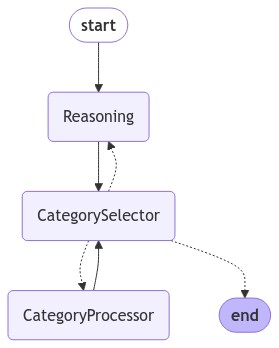

In [38]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [39]:
# user_id = "df50566f-b08e-43eb-9a96-960ad2923b6d"
# user_id = "08e99fcc-070a-406e-9c21-214b9db362fa"
# user_id = "e8291bc7-3eaf-434f-9a15-26091d02aae4"
# out = graph.invoke({"strategy":[]})

In [40]:
# out['strategy']

In [41]:
# user_ids = aug_all_user_data['user_id'].unique().tolist()

In [42]:
user_ids = ["df50566f-b08e-43eb-9a96-960ad2923b6d", "08e99fcc-070a-406e-9c21-214b9db362fa", "e8291bc7-3eaf-434f-9a15-26091d02aae4"]
user_ids = aug_all_user_data['user_id'].unique().tolist()
user_ids = ["5ad22554-c92b-4aa9-bdbf-ba41ba39237a"]

all_user_data = []
for local_user_id in user_ids:
    print("Getting startegy for user_id:", local_user_id)
    global user_id
    user_id = local_user_id
    try:
        out = graph.invoke({"strategy":[]})
        print(out)
        strategy_dict = {}
        for ele in out['strategy']:
            strategy_dict['user_id'] = user_id
            strategy_dict[ele["category"]] = {
                "observations" : ele["observations"],
                "assumptions" : ele["assumptions"],
                "strategy" : ele["strategy"],
                "info_needed" :  ele["info_needed"]
            }
        all_user_data.append(strategy_dict)
    except:
        continue

Getting startegy for user_id: 5ad22554-c92b-4aa9-bdbf-ba41ba39237a
{'reasoning': [{'Category': 'bills & utilities', 'savings_explanation': 'The spending has significantly decreased from last month (INR 3999 to INR 1440). This indicates that there might be opportunities to further reduce utility expenses, possibly by reviewing service providers or eliminating unnecessary subscriptions.'}, {'Category': 'travel', 'savings_explanation': "There are new travel expenses this month (INR 4132) compared to last month (INR 0). It's essential to evaluate if these trips were necessary or if cheaper alternatives (like public transport or less expensive accommodations) could have been utilized."}, {'Category': 'shopping', 'savings_explanation': 'Spending on shopping increased from INR 541 to INR 6033. This spike suggests that there may have been impulsive buys. Implementing a strict budget or shopping list could help in controlling unnecessary spending.'}, {'Category': 'money transfers', 'savings_exp

In [43]:
all_user_data

[{}]

In [44]:
pd.json_normalize(all_user_data).to_csv("./pfm_user_data_3.csv", index = False)

In [70]:
# strategy_dict = {}
# for ele in out['strategy']:
#     strategy_dict['user_id'] = user_id
#     strategy_dict[ele["category"]] = {
#         "observations" : ele["category"],
#         "assumptions" : ele["assumptions"],
#         "strategy" : ele["strategy"],
#         "info_needed" : : ele["strategy"]
#     }

In [246]:
len(out['strategy'])

4

In [45]:
user_id = "5ad22554-c92b-4aa9-bdbf-ba41ba39237a"
print(get_data_cuts_for_category("food & drinks"))

In [226]:
from langchain_core.messages import HumanMessage
# question = "can you look at my transaction and tell me how can I reduce my monthly expenses?"
events = graph.stream({"reasoning":[]},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    #if i > 0:
        #print(step)
        #mod_step[-1].pretty_print()

Step 0
Step 1
Step 2
food & drinks
Step 3
Step 4
groceries
Step 5
Step 6
rent
Step 7
Step 8
uncategorised
Step 9
Step 10


In [68]:
from langchain_core.messages import HumanMessage
# question = "can you look at my transaction and tell me how can I reduce my monthly expenses?"
events = graph.stream({"temp":"", "error":[]},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    if i > 0:
        print(step)
        mod_step = step['intermediate_steps']
        mod_step[-1].pretty_print()

Step 0
content='' additional_kwargs={'tool_calls': [{'id': 'call_9T73sZfTrSzdzLyJgcqA93w5', 'function': {'arguments': '{"reasoning": [{"Category": "edge card bill", "savings_explanation": "This category shows a significant decrease in spending (from 10883 to 4893). This suggests an opportunity to further reduce reliance on this credit option or explore better alternatives for any ongoing payments that could be paid off in full to avoid future interest."}, {"Category": "food & drinks", "savings_explanation": "Spending has increased from 179 to 2627. This is a substantial rise, indicating a potential area to monitor closely, as it may reflect more frequent dining out or excessive takeout. Encouraging meal prep or dining at home can help reduce costs."}, {"Category": "groceries", "savings_explanation": "Groceries have seen a rise in spending from 125 to 1479. This indicates increased purchasing, which could be streamlined by planning meals, using shopping lists, or taking advantage of dis

IndexError: list index out of range

In [63]:
# col_intr = ['transactionDateTime','transactionAmount', 'payer', 'category']
# df[col_intr]

In [53]:
df.columns

Index(['mmUUID', 'customerID', 'accountID', 'jupiterTransactionID',
       'bankTransactionReference', 'creditDebitIndicator',
       'transactionDateTime', 'transactionStatus', 'reconStatus',
       'transactionAmount', 'transactionChannel', 'transactionType',
       'transactionExpiry', 'payer', 'payerParticulars', 'payee',
       'payeeParticulars', 'merchant', 'merchantLogo', 'category',
       'categoryLogo', 'subCategory', 'bankName', 'product', 'location',
       'tags', 'note', 'remarks', 'receipts', 'fraudDeclineCode',
       'fraudParticulars', 'adaParticulars', 'suggestedTags', 'mandateID',
       'mandateParticulars', 'attachedService', 'lineOfTransaction',
       'clearanceStatus', 'responseCode', 'declineCode',
       'categorisationMetadata', 'initiationMode', 'modelCategory',
       'parentTransactionID', 'isUserUpdatedCategory', 'transactionLocation',
       'internationalTransactionMetaData', 'acquirerReferenceNumber',
       'applicationProvider', 'mccCode', 'payerPa

In [71]:
df.sample(10)

,transactionDateTime,transactionAmount,payee,category
135,2024-08-10T12:49:16.812774Z,75.0,kasthuri m,travel
15,2024-08-20T00:00:00Z,43000.0,mangukia a,rent
147,2024-07-06T00:00:00Z,30.0,cssailokesh200-,uncategorised
97,2024-07-03T14:23:17.348580Z,203.0,geddit convenience private limited,groceries
47,2024-07-03T04:03:26.113541Z,5000.0,nippon india mutual fund - sip,investments
54,2024-08-27T17:36:46.416083Z,5000.0,dhameliya vatsalkumar nareshbhai,self transfers
100,2024-08-25T17:43:44.855862Z,180.0,mahesha d s,groceries
133,2024-08-20T16:05:56.165897Z,80.0,mahesha d s,groceries
70,2024-08-19T18:30:24.520653Z,3601.0,henil bharatbhai patel,uncategorised
57,2024-07-03T01:01:15Z,5000.0,motilal oswal mutual fund - sip,investments
